# Recoinize

[https://github.com/nicknochnack/FaceRecognition](https://github.com/nicknochnack/FaceRecognition/blob/main/Facial%20Verification%20with%20a%20Siamese%20Network%20-%20Final.ipynb)

## TODOs

- [ ] Set up a websocket server to dynamically update srouces files into paperspace
- [ ] Update python to the latest version in paperspace
- [ ] Update all dependencies
- [ ] Use a python environment
- [ ] Autodetect the kernel location (local, paperspace)
- [ ] Add a nice logger to remove unwanted outputs in the notebook

## Settings

These are the settings for the notebook. You can change them to fit your needs.

- `KERNEL_LOCATION`: (`'local'` or `'paperspace'`) This setting is here to load the right libraries. Paperspace devices have a different setup than local machines.
- `LOG_LEVEL`: (`'DEBUG'`, `'INFO'`, `'WARNING'`, `'ERROR'`, `'CRITICAL'`) This setting is here to set the log level for the notebook.
- `DATASET_SOURCE`: (`'local'` or `'huggingface'`) This setting is here to load the dataset from the local machine or from the HuggingFace repos.
- `DATASET_NAME`: (`str`) This setting is here to set the URL of the HuggingFace repos.

In [3]:
KERNEL_LOCATION = "local"                # TODO: auto-detect kernel location
LOG_LEVEL = "info"                       # TODO: handle log level
DATASET_SOURCE = "huggingface"
DATASET_NAME = "photonsquid/coins-euro"

Set auto-reload for the notebook, so all modifications in other python files will be loaded automatically in this Notebook.

In [4]:
%load_ext autoreload
%autoreload 2

If you want, you can check what is your GPU.

In [5]:
from src.helpers.cmd import print_gpu_name
print_gpu_name()

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.



Exception: 'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


## Install dependencies

This command will install all the dependencies that are in the `requirements.txt` file.

In [6]:
from src.helpers.install import install_requirements
# install_requirements()

## Pull code from GitHub

If you're using Paperspace, you'll have to pull the code from GitHub each time there is a commit.
If you're using a local machine, this step will be skipped.

In [7]:
if KERNEL_LOCATION == "paperspace":
    # from src.helpers.cmd import git_update
    # git_update("live-edit", force=True, show_output=False) # TODO: fix errors when running this
    !git fetch
    !git pull

## Import dependencies

In [8]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf

from src.dataset import create_triplets

## Get data

In [9]:
if (DATASET_SOURCE == "huggingface"):
    from datasets.load import load_dataset as HF_load_dataset
    dataset = HF_load_dataset('photonsquid/coins-euro')
elif (DATASET_SOURCE == "local"):
    from src.helpers.load_data import load_data as local_load_data
    dataset = local_load_data("data/tests")
else:
    print("Invalid dataset source")

c:\Users\bsodium\Code\GitHub\Recoinize\.env\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using custom data configuration photonsquid--coins-euro-b75261052d3e19e0
Found cached dataset parquet (C:/Users/bsodium/.cache/huggingface/datasets/photonsquid___parquet/photonsquid--coins-euro-b75261052d3e19e0/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 3/3 [00:00<00:00, 32.98it/s]


## Prepare data

In [10]:
train_dataset = dataset["train"]

In [11]:
anchor_imgs, positive_imgs, negative_imgs = create_triplets(train_dataset)

In [12]:
# convert imgs and labels to tensors
anchor_imgs = tf.convert_to_tensor(anchor_imgs)
positive_imgs = tf.convert_to_tensor(positive_imgs)
negative_imgs = tf.convert_to_tensor(negative_imgs)

In [13]:
# create a tensorflow dataset
data = tf.data.Dataset.from_tensor_slices((anchor_imgs, positive_imgs, negative_imgs))

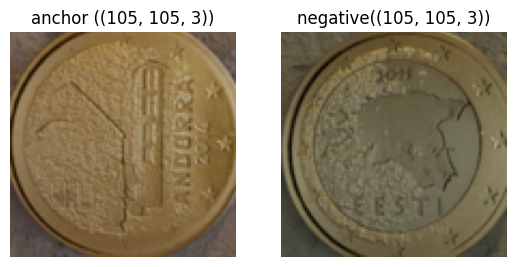

In [14]:
for image in data:
    anchor = image[0].numpy()
    positive = image[1].numpy()
    negative = image[2].numpy()

    # show the images
    plt.subplot(1, 3, 1)
    plt.imshow(anchor)
    plt.axis('off')
    plt.title("anchor (" + str(image[0].shape) + ")")
    plt.subplot(1, 3, 2)
    plt.imshow(positive)
    plt.axis('off')
    plt.title("positive (" + str(image[1].shape) + ")")
    plt.subplot(1, 3, 3)
    plt.imshow(negative)
    plt.axis('off')
    plt.title("negative (" + str(image[2].shape) + ")")
    plt.show()
    break

## Build model

In [20]:
from src.models import make_embedding, make_triplet_model

In [21]:
embedding = make_embedding()
triplet_model = make_triplet_model(embedding)

In [22]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 21, 21, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 18, 18, 128)       26

| Layer            | (type)         | Output Shape          | Param  |
| ---------------- | -------------- | --------------------- | ------ |
| input_image      | (InputLayer)   | [(None, 105, 105, 3)] | 0      |
| conv2d_16        | (Conv2D)       | (None, 96, 96, 64)    | 19264  |
| max_pooling2d_12 | (MaxPooling2D) | (None, 48, 48, 64)    | 0      |
| conv2d_17        | (Conv2D)       | (None, 42, 42, 128)   | 401536 |
| max_pooling2d_13 | (MaxPooling2D) | (None, 21, 21, 128)   | 0      |
| conv2d_18        | (Conv2D)       | (None, 18, 18, 128)   | 262272 |
| max_pooling2d_14 | (MaxPooling2D) | (None, 9, 9, 128)     | 0      |
| conv2d_19        | (Conv2D)       | (None, 6, 6, 256)     | 524544 |
| flatten_4        | (Flatten)      | (None, 9216)          | 0      |

- Total params: 38,960,448
- Trainable params: 38,960,448
- Non-trainable params: 0

In [23]:
triplet_model.summary()

Model: "TripletNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive_img (InputLayer)      [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative_img (InputLayer)      [(None, 105, 105, 3  0           []                               
                                )]                                                   

| Layer          | (type)       | Output Shape          | Param    | Connected to                               |
| -------------- | ------------ | --------------------- | -------- | ------------------------------------------ |
| input_img      | (InputLayer) | [(None, 105, 105, 3)] | 0        | []                                         |
| validation_img | (InputLayer) | [(None, 105, 105, 3)] | 0        | []                                         |
| embedding      | (Functional) | (None, 4096)          | 38960448 | `['input_img[0][0]','validation_img[0][0]']` |
| distance       | (L1Dist)     | (None, 4096)          | 0        | `['embedding[0][0]','embedding[1][0]']`      |
| dense_8        | (Dense)      | (None, 1)             | 4097     | `['distance[0][0]']`                         |

- Total params: 38,964,545
- Trainable params: 38,964,545
- Non-trainable params: 0


In [33]:
data = data.cache()
data = data.shuffle(buffer_size=10000)


# Training partition
# size of one batch
train_data = data.batch(16)

# prefetch data for faster training (prefetching means that the data is
# preprocessed (e.g. batched) while the model is training on the previous batch)
# 8 is the number of batches that will be prepared in advance
train_data = train_data.prefetch(8)

opt = tf.keras.optimizers.Adam(1e-4)  # 0.0001

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=opt, model=triplet_model)

triplet_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

TypeError: in user code:


    TypeError: outer_factory.<locals>.inner_factory.<locals>.tf__create_triplets() takes 2 positional arguments but 3 were given


In [25]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor, positive, and negative image
        X = batch[:3]
        # Get label
        y = batch[3]

        # Forward pass
        y_hat = triplet_model(X, training=True)
        # Calculate loss
        loss = triplet_loss(y, y_hat)
    print(loss) # should be saved to array ideally

    # Calculate gradients
    grad = tape.gradient(loss, triplet_model.trainable_variables)

    # Calculate updated weights and apply to triplet model
    opt.apply_gradients(zip(grad, triplet_model.trainable_variables))

    # Return loss
    return loss

In [26]:
from tensorflow.keras.metrics import Precision, Recall


def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Creating a metric object
        r = Recall()
        p = Precision()

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = triplet_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [27]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50


StagingError: in user code:

    File "C:\Users\bsodium\AppData\Local\Temp\ipykernel_26472\1729283384.py", line 9, in train_step  *
        y = batch[3]

    IndexError: tuple index out of range


## Evaluate model

In [12]:
test_dataset = dataset["test"]

In [13]:
test_anchor_imgs, test_validation_imgs, test_labels = create_triplets(test_dataset)

In [14]:
# convert imgs and labels to tensors
test_anchor_imgs = tf.convert_to_tensor(test_anchor_imgs)
test_validation_imgs = tf.convert_to_tensor(test_validation_imgs)
test_labels = tf.convert_to_tensor(test_labels)

In [15]:
# create a tensorflow dataset
test_data = tf.data.Dataset.from_tensor_slices(
    (test_anchor_imgs, test_validation_imgs, test_labels))

In [16]:
test_data = test_data.cache()
test_data = test_data.shuffle(buffer_size=10000)
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [17]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
y_hat = siamese_model.predict([test_input, test_val])

In [116]:
# Post processing the results
results = np.array([1 if prediction > 0.5 else 0 for prediction in y_hat])

In [ ]:
# compute difference between predicted and true labels
diff = results - np.array(y_true)

# compute accuracy
accuracy = 1 - (np.count_nonzero(diff) / len(diff))
accuracy